特征矩阵形状 (包含 Unigram 和 Bigram): (1312, 5000)


D:\Python\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:29:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
D:\Python\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:29:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
D:\Python\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:29:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
D:\Python\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:29:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
D:\Python\Lib\site-packages\xgbo


10-Fold CV 平均准确率: 0.5648


D:\Python\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:29:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Test Set Report ---
                         precision    recall  f1-score   support

    Alzheimer's Disease       0.53      0.49      0.51        68
Frontotemporal Dementia       0.75      0.64      0.69        59
     Lewy Body Dementia       0.65      0.61      0.63        64
    Parkinson's Disease       0.48      0.57      0.52        68
      Vascular Dementia       0.63      0.67      0.65        70

               accuracy                           0.60       329
              macro avg       0.61      0.60      0.60       329
           weighted avg       0.60      0.60      0.60       329



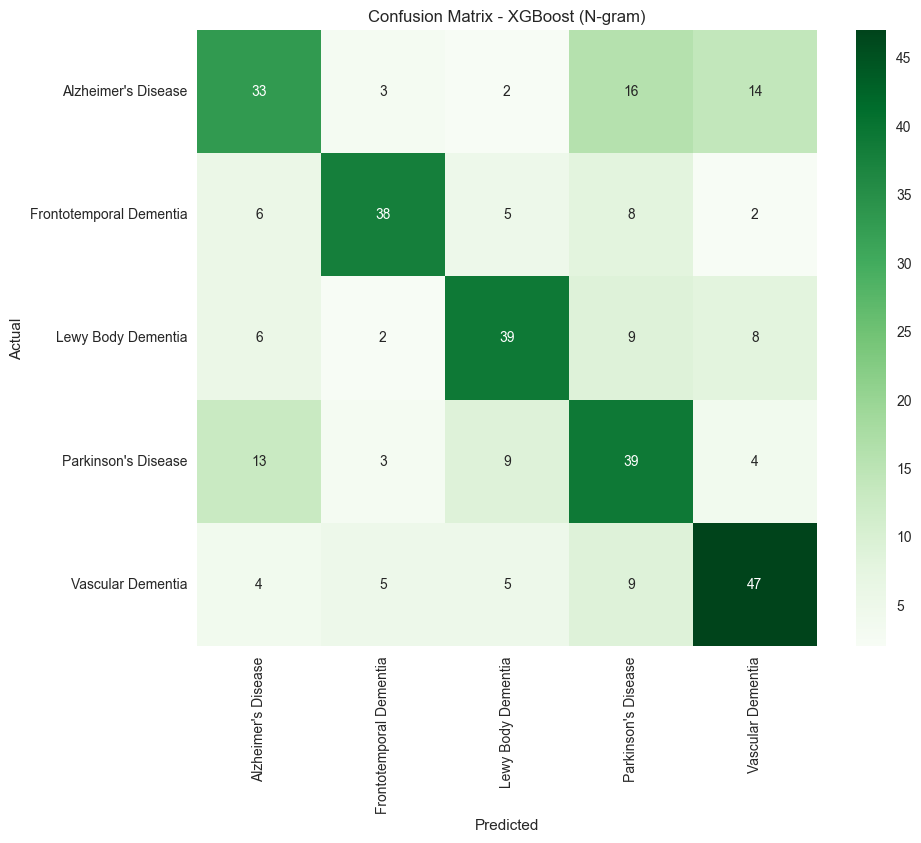

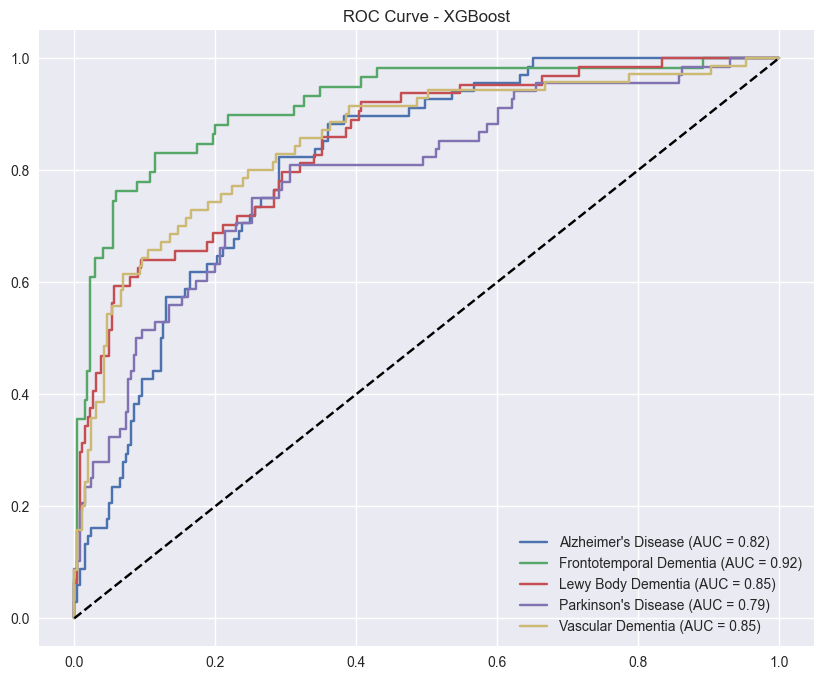

C:\Users\yeyude\AppData\Local\Temp\ipykernel_5892\3658958133.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_scores, y=top_features, palette="viridis")


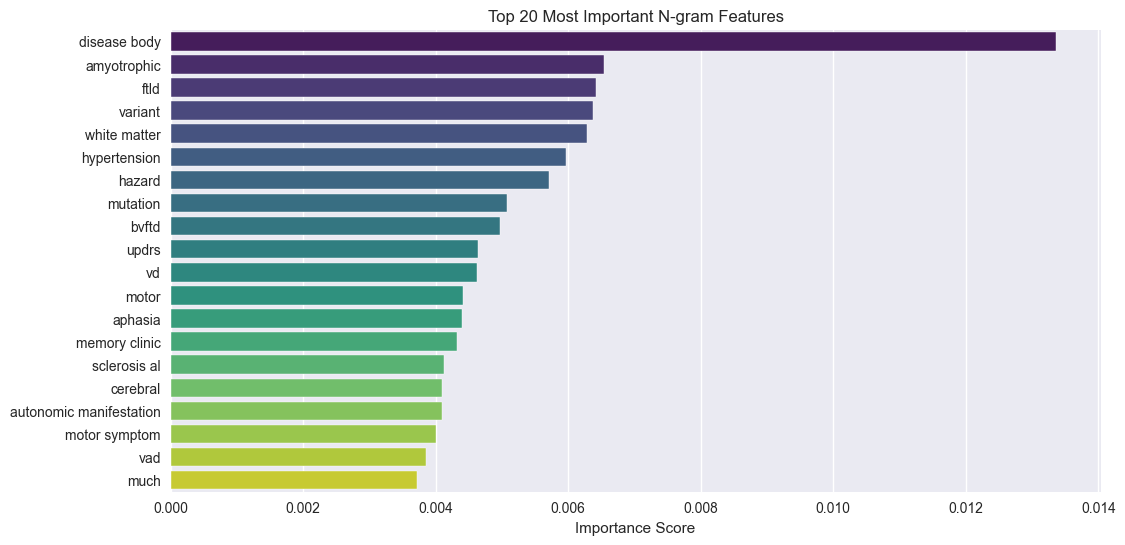

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc

# 设置绘图风格
plt.style.use('seaborn-v0_8')

# ==========================================
# 1. 数据准备
# ==========================================
df = pd.read_csv('cleaned_data.csv')
df['Cleaned_Content'] = df['Cleaned_Content'].fillna('')

# XGBoost 需要数字型的标签，先进行编码
le = LabelEncoder()
df['Label_Encoded'] = le.fit_transform(df['Label'])
class_names = le.classes_

# ==========================================
# 2. 特征工程: N-gram (BoW with Bigrams)
# ==========================================
# ngram_range=(1, 2) 表示同时使用单个词(Unigram)和双词短语(Bigram)
# 例如: "lewy body", "vascular dementia" 这种短语会被作为一个特征保留
vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=5000)

X = df['Cleaned_Content']
y = df['Label_Encoded']

# 划分训练集和测试集
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 向量化
X_train_vec = vectorizer.fit_transform(X_train_raw)
X_test_vec = vectorizer.transform(X_test_raw)

print(f"特征矩阵形状 (包含 Unigram 和 Bigram): {X_train_vec.shape}")

# ==========================================
# 3. 模型训练: XGBoost Classifier
# ==========================================
xgb_model = XGBClassifier(
    n_estimators=100,       # 树的数量
    learning_rate=0.1,      # 学习率
    max_depth=6,            # 树的深度，防止过拟合
    objective='multi:softprob', # 多分类概率
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1               # 并行计算
)

# 10折交叉验证
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_model, X_train_vec, y_train, cv=cv, scoring='accuracy')

print(f"\n10-Fold CV 平均准确率: {cv_scores.mean():.4f}")

# 在全量训练集上训练
xgb_model.fit(X_train_vec, y_train)

# ==========================================
# 4. 评估与可视化
# ==========================================
y_pred = xgb_model.predict(X_test_vec)
y_prob = xgb_model.predict_proba(X_test_vec)

print("\n--- Test Set Report ---")
print(classification_report(y_test, y_pred, target_names=class_names))

# [图表 1] 混淆矩阵
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - XGBoost (N-gram)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# [图表 2] ROC 曲线
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve - XGBoost')
plt.legend(loc="lower right")
plt.show()

# [图表 3] 特征重要性 (Feature Importance)
# XGBoost 自带特征重要性，可以显示哪些 N-gram 最关键
feature_names = vectorizer.get_feature_names_out()
sorted_idx = xgb_model.feature_importances_.argsort()[::-1][:20] # 取前20个
top_features = [feature_names[i] for i in sorted_idx]
top_scores = xgb_model.feature_importances_[sorted_idx]

plt.figure(figsize=(12, 6))
sns.barplot(x=top_scores, y=top_features, palette="viridis")
plt.title("Top 20 Most Important N-gram Features")
plt.xlabel("Importance Score")
plt.show()